# **Data Preprocessing Notebook for Hematopoietic Cell Transplantation (HCT) Data**

# **1. INITIAL SETUP & DATA LOADING**

In [ ]:
!pip install lifelines
!pip install scikit-survival

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=d94bba97a82b365546be1d179dcfabf33ada3eb2a8df3982cfc3e5063c0bc592
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sklearn.preprocessing import quantile_transform
from lifelines import CoxPHFitter
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
import os

In [ ]:
!git clone https://github.com/mourad365/ESPDC_1_Comp.git

Cloning into 'ESPDC_1_Comp'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 1.27 MiB | 3.23 MiB/s, done.


In [ ]:
data_path = "/content/ESPDC_1_Comp/data/"
os.listdir(data_path)  # List files in the data folder
train_data = pd.read_csv(data_path + "train.csv")

# **2. DATA EXPLORATION**

In [ ]:
# Basic dataset inspection
print("Initial shape:", train_data.shape)
print("Columns:\n", train_data.columns.tolist())
train_data.head()

Initial shape: (28800, 60)
Columns:
 ['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'efs', 'efs_time']


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,<NA>,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,Mel not given,8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,Mel not given,8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,<NA>,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,Mel not given,8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,Mel not given,8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [ ]:
# Data type and null value analysis
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               19156 non-null  object 
 2   psych_disturb           26592 non-null  object 
 3   cyto_score              19336 non-null  object 
 4   diabetes                26540 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26480 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26748 non-null  object 
 13  pulm_severe             26485 non-null  object 
 14  prim_disease_hct        28800 non-null

In [ ]:
# Categorical columns analysis
categorical_columns = train_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = sorted(train_data[col].dropna().unique())
    print(f"{col}: {unique_values}")

dri_score: ['High', 'Intermediate', 'Low', 'Very high']
psych_disturb: ['No', 'Yes']
cyto_score: ['Favorable', 'Intermediate', 'Normal', 'Other', 'Poor']
diabetes: ['No', 'Yes']
tbi_status: ['No TBI', 'TBI + Cy +- Other', 'TBI +- Other, -cGy, fractionated', 'TBI +- Other, -cGy, single', 'TBI +- Other, -cGy, unknown dose', 'TBI +- Other, <=cGy', 'TBI +- Other, >cGy', 'TBI +- Other, unknown dose']
arrhythmia: ['No', 'Yes']
graft_type: ['Bone marrow', 'Peripheral blood']
vent_hist: ['No', 'Yes']
renal_issue: ['No', 'Yes']
pulm_severe: ['No', 'Yes']
prim_disease_hct: ['AI', 'ALL', 'AML', 'CML', 'HD', 'HIS', 'IEA', 'IIS', 'IMD', 'IPA', 'MDS', 'MPN', 'NHL', 'Other acute leukemia', 'Other leukemia', 'PCD', 'SAA', 'Solid tumor']
cmv_status: ['+/+', '+/-', '-/+', '-/-']
tce_imm_match: ['G/B', 'G/G', 'H/B', 'H/H', 'P/B', 'P/G', 'P/H', 'P/P']
rituximab: ['No', 'Yes']
prod_type: ['BM', 'PB']
cyto_score_detail: ['Favorable', 'Intermediate', 'Poor']
conditioning_intensity: ['MAC', 'N/A, F(pre-TED) n

# **3. DATA CLEANING**

In [ ]:
# Handle missing values and N/A strings
na_replacements = {
    "N/A - non-malignant indication": pd.NA,
    "N/A, Mel not given": "Mel not given",
    "Not done": pd.NA,
    "Not tested": pd.NA,
    "N/A - pediatric": pd.NA,
    "TBD cytogenetics": pd.NA,
    "TBD": pd.NA,
    "N/A": pd.NA,
    "N/A - disease not classifiable": pd.NA,
    "N/A - non-malignant": pd.NA,
    "Missing disease status": pd.NA,
    "Intermediate - TED AML case <missing cytogenetics": "Intermediate",
    "High - TED AML case <missing cytogenetics": "High"

}
train_data.replace(na_replacements, inplace=True)

# Drop columns with >30% missing data
threshold = len(train_data) * 0.3
data_clean = train_data.dropna(axis=1, thresh=threshold)

# Imputation
# Numerical: Median imputation
num_cols = data_clean.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    data_clean[col] = data_clean[col].fillna(data_clean[col].median())

# Categorical: Mode imputation
cat_cols = data_clean.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    data_clean[col] = data_clean[col].fillna(data_clean[col].mode()[0])

# **4. FEATURE ENGINEERING**

In [ ]:
# Ordinal Encoding (for variables with inherent order)
ordinal_cols = ['dri_score', 'cyto_score', 'cyto_score_detail']
ordinal_encoder = OrdinalEncoder(categories=[
    ['Low', 'Intermediate', 'High','Very high'],
    ['Favorable', 'Intermediate', 'Normal', 'Poor', 'Other'],
    ['Favorable', 'Intermediate', 'Poor']
])
data_clean[ordinal_cols] = ordinal_encoder.fit_transform(data_clean[ordinal_cols])

# Binary Encoding (Yes/No columns)
yn_cols = ['psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist',
          'renal_issue', 'pulm_severe', 'rituximab', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate']
for col in yn_cols:
    data_clean[col] = data_clean[col].map({'Yes': 1, 'No': 0})

# Special binary encoding
data_clean['donor_related'] = data_clean['donor_related'].map(
    {'Unrelated': 0, 'Related': 1, 'Multiple donor (non-UCB)': 2})

# Encoding other binary columns
other_bi_cols = ['graft_type', 'prod_type', 'mrd_hct', 'melphalan_dose']
for col in other_bi_cols:
    uni_val = data_clean[col].unique()
    if len(uni_val) == 2:
        data_clean[col] = data_clean[col].map({uni_val[0]: 0, uni_val[1]: 1})

# One-Hot Encoding (Nominal variables)
nominal_cols = data_clean.select_dtypes(include=['object']).columns
data_clean = pd.get_dummies(data_clean, columns=nominal_cols, drop_first=True)


# **5. OUTLIER HANDLING & SCALING**

In [ ]:
# IQR-based outlier capping
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[col].clip(lower=Q1-1.5*IQR, upper=Q3+1.5*IQR)

data_km = data_clean.copy()
data_rsf = data_clean.copy()
# Apply outlier capping to numerical columns
for col in num_cols:
    data_clean[col] = cap_outliers(data_clean, col)

# Standardization
scaler = StandardScaler()
data_clean[num_cols] = scaler.fit_transform(data_clean[num_cols])

# **6. FINAL DATA CHECK**

In [ ]:
print("Final dataset shape:", data_clean.shape)
print("Missing values:", data_clean.isnull().sum().sum())
data_clean.head()

Final dataset shape: (28800, 119)
Missing values: 0


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,arrhythmia,hla_low_res_6,graft_type,...,sex_match_M-F,sex_match_M-M,race_group_Asian,race_group_Black or African-American,race_group_More than one race,race_group_Native Hawaiian or other Pacific Islander,race_group_White,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched
0,-1.731991,1.0,0,3.0,0,0.0,0.651445,0,0.668543,0,...,True,False,False,False,True,False,False,False,False,True
1,-1.731870,1.0,0,1.0,0,0.0,0.651445,0,0.668543,1,...,False,False,True,False,False,False,False,False,False,True
2,-1.731750,1.0,0,3.0,0,0.0,0.651445,0,0.668543,0,...,False,False,False,False,True,False,False,False,False,True
3,-1.731630,2.0,0,1.0,0,0.0,0.651445,0,0.668543,0,...,False,True,False,False,False,False,True,False,False,True
4,-1.731510,2.0,0,3.0,0,0.0,0.651445,0,0.668543,1,...,True,False,False,False,False,False,False,False,False,True


# **7. TRAINING THE MODELS**

# KAPLAN-MEIER ESTIMATOR

In [ ]:
def kaplan_meier_estimator(time, event):
    """
    Compute the Kaplan-Meier survival estimate for given time-to-event data.

    Arguments:
    time (list/array): Array of observed times (event or censoring times).
    event (list/array): Array of event indicators (1 = event occurred, 0 = censored).

    Returns:
    time_points (list): Time points where the survival curve changes.
    survival_curve (list): Survival probabilities corresponding to time_points.
    """
    # Combine and sort data by time, with events before censored at the same time
    data = sorted(zip(time, event), key=lambda x: (x[0], -x[1]))

    # Initialize variables
    n_risk = len(data)
    survival = 1.0
    time_points = [0.0]
    survival_curve = [survival]

    current_time = None
    d_i = 0  # Number of events at current time
    c_i = 0  # Number of censored at current time

    for t, e in data:
        if t != current_time:
            # Process previous time (if any)
            if current_time is not None:
                if d_i > 0:
                    # Update survival probability
                    survival *= (1 - d_i / n_risk)
                    time_points.append(current_time)
                    survival_curve.append(survival)
                # Reduce number at risk after this time
                n_risk -= (d_i + c_i)
                # Reset counters
                d_i = 0
                c_i = 0
            current_time = t
        # Update event/censor counts
        if e == 1:
            d_i += 1
        else:
            c_i += 1

    # Process the last observed time
    if current_time is not None:
        if d_i > 0:
            survival *= (1 - d_i / n_risk)
            time_points.append(current_time)
            survival_curve.append(survival)
        n_risk -= (d_i + c_i)

    return time_points, survival_curve

In [ ]:
train_km, test_km= train_test_split(data_km, test_size=0.2, random_state=42)

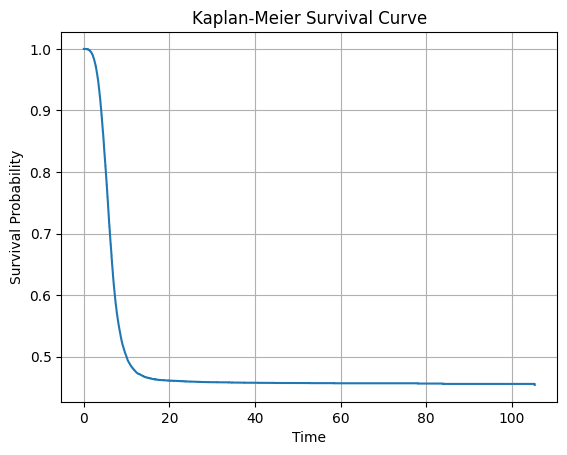

In [ ]:
time_points, survival_curve = kaplan_meier_estimator(train_km['efs_time'], train_km['efs'])

#The Kaplan-Meier plot
plt.step(time_points, survival_curve, where='post')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve')
plt.grid(True)
plt.show()

# COX PROPORTIONAL HAZARDS

In [ ]:
# Ensure `efs_time` is properly formatted
data_clean = data_clean.copy()  # Avoid modifying original dataset

features = [f for f in data_clean.columns if f not in ['ID', 'efs', 'efs_time']]

def transform_quantile(time, event):
    """Transform efs_time using quantile scaling"""
    transformed = np.full(len(time), np.nan)

    # Ensure we have valid event=1 values before transforming
    eventful_times = -time[event == 1].values.reshape(-1, 1)
    if len(eventful_times) > 0:
        transformed_dead = quantile_transform(eventful_times).ravel()
        transformed[event == 1] = transformed_dead
        transformed[event == 0] = transformed_dead.min() - 0.3
    else:
        print("Warning: No eventful times found! Using a simple log transformation.")
        transformed = np.log1p(time)  # Alternative transformation

    return transformed

# Apply transformation
data_clean["target"] = transform_quantile(time=data_clean["efs_time"], event=data_clean["efs"])

# Drop non-numeric columns and ensure target is included
data_cox = data_clean[features + ['target', 'efs']].select_dtypes(include=['float64', 'int64'])

# Handle missing values
#data_cox.dropna(inplace=True)  # Option 1: Remove rows with NaNs
data_cox.fillna(data_cox.median(), inplace=True)  # Option 2: Fill NaNs with median

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
data_cox = pd.DataFrame(selector.fit_transform(data_cox), columns=data_cox.columns[selector.get_support()])


In [ ]:

# Fit Cox model
cph = CoxPHFitter()
cph.fit(data_cox, duration_col='target', event_col='efs', show_progress=True)

# Summary and assumptions check
print(cph.print_summary())
cph.check_assumptions(data_cox, p_value_threshold=0.05)


Iteration 1: norm_delta = 3.95e-01, step_size = 0.9500, log_lik = -266928.21619, newton_decrement = 2.04e+03, seconds_since_start = 2.3
Iteration 2: norm_delta = 6.23e-02, step_size = 0.9500, log_lik = -264861.24813, newton_decrement = 3.98e+01, seconds_since_start = 3.7
Iteration 3: norm_delta = 4.80e-03, step_size = 0.9500, log_lik = -264821.00928, newton_decrement = 2.20e-01, seconds_since_start = 5.1
Iteration 4: norm_delta = 1.05e-05, step_size = 1.0000, log_lik = -264820.78924, newton_decrement = 1.00e-06, seconds_since_start = 6.6
Iteration 5: norm_delta = 5.11e-11, step_size = 1.0000, log_lik = -264820.78924, newton_decrement = 2.39e-17, seconds_since_start = 8.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 28800 total observations, 0 right-censored observations>
             duration col = 'target'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 28800
number of events observed = 28800
   partial log-likelihood = -264820.79
         time fit was run = 2025-02-20 00:18:46 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
dri_score            0.11      1.12      0.01            0.09            0.14                1.09                1.15
psych_disturb        0.08      1.08      0.02            0.04            0.11                1.04                1.12
cyto_score           0.03      1.03      0.01            0.02            0.04                1.02                1.05
diabetes             0.08      1.08      0.02            0.04            0.11                1.04                1.12
hla_high_res_8      -0.02      0.98      0.03           -0.08            0.03                0.92                1.03
arrhythmia           0.02      1.02      0.03           -0.04            0.08                0.96                1.08
hla_low_res_6       -0.04      0.96      0.04           -0.11            0.03                0.89                1.03
graft_type           0.09      1.09      0.03            0.04            0.14                1.04                1.15
vent_hist            0.04      1.04      0.04           -0.03            0.11                0.97                1.11
pulm_severe          0.20      1.22      0.03            0.14            0.25                1.16                1.28
hla_high_res_6      -0.08      0.93      0.03           -0.13           -0.02                0.88                0.98
hla_high_res_10      0.07      1.07      0.02            0.03            0.10                1.03                1.11
hla_nmdp_6          -0.04      0.96      0.01           -0.07           -0.02                0.94                0.98
rituximab            0.01      1.01      0.04           -0.07            0.09                0.93                1.09
hla_match_drb1_low   0.05      1.05      0.02            0.01            0.08                1.01                1.08
prod_type            0.11      1.11      0.03            0.06            0.16                1.06                1.17
cyto_score_detail    0.18      1.20      0.02            0.15            0.21                1.16                1.24
year_hct             0.32      1.38      0.01            0.31            0.33                1.36                1.40
obesity              0.06      1.06      0.02            0.01            0.11                1.01                1.11
mrd_hct             -0.01      0.99      0.02           -0.04            0.03                0.96                1.03
in_vivo_tcd         -0.11      0.89      0.01           -0.14           -0.08                0.87                0.92
hepatic_severe      -0.12      0.88      0.03           -0.18           -0.07                0.84                0.93
donor_age           -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
prior_tumor         -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
hla_match_b_low      0.08      1.09      0.02            0.05            0.12                1.05                1.12
age_at_hct           0.03      1.03      0.01            0.02            0.05                1.02                1.05
hla_match_a_low     -0.03      0.97      0.02           -0.06           -0.00                0.94                1.00
rheum_issue         -0.13      0.88      0.05           -0.22           -0.03                0.80                0.97
hla_match_b_high     0.03      1.03      0.01            0.01            0.05                1.0

None
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 28800 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
age_at_hct          km             57.64 <0.005     44.85
                    rank           57.95 <0.005     45.08
arrhythmia          km              2.66   0.10      3.28
                    rank            2.69   0.10      3.30
cardiac             km             10.30 <0.005      9.55
                    rank           10.32 <0.005      9.57
comorbidity_score   km            115.95 <0.005     87.41
                    rank          116.60 <0.005     87.88
cyto_score          km             80.94 <0.005     61.90
                    rank           81.59 <0.005     62.37
cyto_score_detail   km            105.85 <0.005     80.05
                    rank          106.14 <0.005     80.27
diabetes            km              7.56   0.01      7.38
                    rank            7.51   0.01      7.35
donor_age           km             43.66 <0.005     34.57
                    rank           44.09 <0.005     34.90
donor_related       km             22.31 <0.005     18.71
                    rank           22.58 <0.005     18.92
dri_score           km            336.52 <0.005    247.28
                    rank          338.22 <0.005    248.51
graft_type          km              3.57   0.06      4.08
                    rank            3.55   0.06      4.07
hepatic_mild        km              1.75   0.19      2.43
                    rank            1.77   0.18      2.45
hepatic_severe      km             17.84 <0.005     15.34
                    rank           17.87 <0.005     15.37
hla_high_res_10     km              1.59   0.21      2.27
                    rank            1.61   0.20      2.29
hla_high_res_6      km              0.48   0.49      1.03
                    rank            0.49   0.48      1.05
hla_high_res_8      km              0.00   0.98      0.03
                    rank            0.00   0.97      0.04
hla_low_res_10      km              6.11   0.01      6.22
                    rank            6.18   0.01      6.28
hla_low_res_6       km              0.59   0.44      1.18
                    rank            0.60   0.44      1.19
hla_low_res_8       km              0.43   0.51      0.97
                    rank            0.45   0.50      0.99
hla_match_a_low     km             14.28 <0.005     12.63
                    rank           14.38 <0.005     12.71
hla_match_b_high    km              5.82   0.02      5.98
                    rank            5.95   0.01      6.08
hla_match_b_low     km              2.36   0.12      3.00
                    rank            2.36   0.12      3.00
hla_match_drb1_high km              5.98   0.01      6.11
                    rank            6.04   0.01      6.16
hla_match_drb1_low  km              0.22   0.64      0.65
                    rank            0.23   0.63      0.66
hla_nmdp_6          km             10.76 <0.005      9.92
                    rank           10.83 <0.005      9.97
in_vivo_tcd         km              2.38   0.12      3.03
                    rank            2.32   0.13      2.97
karnofsky_score     km            117.93 <0.005     88.85
                    rank          118.41 <0.005     89.19
melphalan_dose      km              0.06   0.81      0.30
                    rank            0.07   0.80      0.33
mrd_hct             km              7.15   0.01      7.06
                    rank            7.23   0.01      7.12
obesity             km              0.07   0.80      0.33
                    rank            0.07   0.79      0.33
prior_tumor         km             10.06 <0.005      9.37
                    rank           10.11 <0.005      9.41
prod_type           km              2.82   0.09      3.42
           



1. Variable 'dri_score' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 4), you can include `strata=['dri_score', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'cyto_score' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 5), you can include `strata=['cyto_score', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'diabetes' failed the non-proportional test: p-value is 0.0060.

   Advice: with so few unique values (only 2), you can include `strata=['diabetes', ...]` in the
call in `.fit`. See documentation in link [E] below.

4. Variable 'vent_hist' failed the non-proportional test: p-value is 0.0216.

   Advice: with so few unique values (only 2), you can include `strata=['vent_hist', ...]` in the
call in `.fit`. See documentation in link [E] below.

5. Variable 'pulm_severe' failed the non-proportional test: p-value is <5e-05.

[]

<Axes: xlabel='log(HR) (95% CI)'>

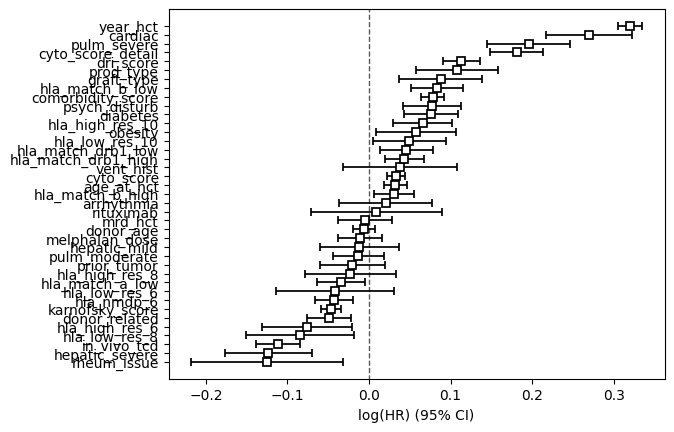

In [ ]:
cph.plot()

<Axes: >

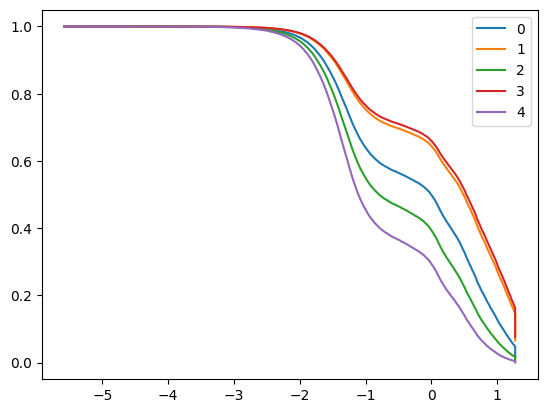

In [ ]:
cph.predict_survival_function(data_cox.iloc[:5]).plot()


# RANDOM SURVIVAL FORREST

In [ ]:
# Ensure 'efs_time' is numeric and 'efs' is binary (1 = efs occurred, 0 = censored)
data_rsf["efs"] = data_rsf["efs"].replace({-1 : 1})
data_rsf["efs_time"] = data_rsf["efs_time"].astype(float)


# Convert to structured array for survival analysis
y = Surv.from_dataframe("efs", "efs_time", data_rsf)

# Extract features
X = data_rsf.drop(columns=["efs", "efs_time"])

#Handling Outliers
num = X.select_dtypes(include=['float64', 'int64']).columns
for col in num:
    X[col] = cap_outliers(data_clean, col)

# Standardization
scaler = StandardScaler()
X[num] = scaler.fit_transform(X[num])

In [ ]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (23040, 117) Test size: (5760, 117)


In [ ]:
# Initialize RSF model
rsf = RandomSurvivalForest(n_estimators=6,
                           min_samples_split=10,
                           min_samples_leaf=3,
                           max_features="sqrt",
                           random_state=42,
                           n_jobs=-1)

# Train the model
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_split=10, n_estimators=6, n_jobs=-1,
                     random_state=42)

In [ ]:
c_index = rsf.score(X_test, y_test)
print(f"C-index on test data: {c_index:.3f}")

C-index on test data: 0.615


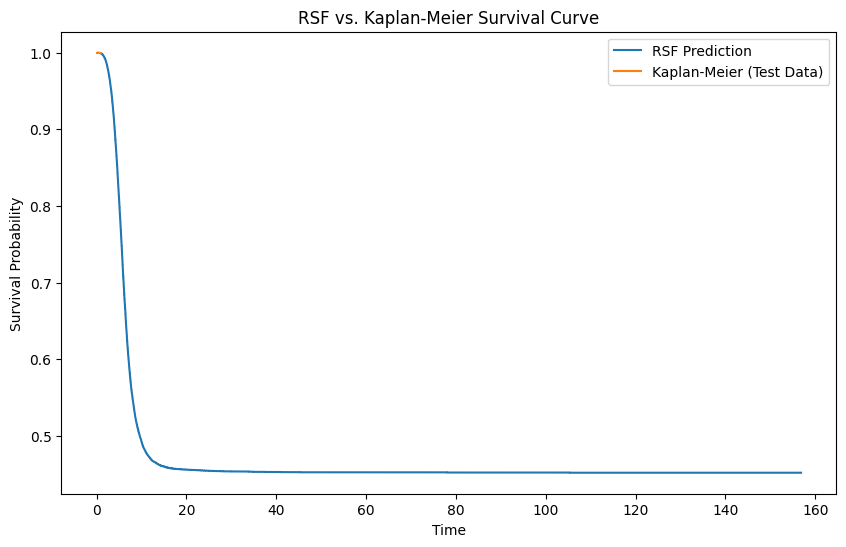

In [ ]:
# Get the model's internal event times (same length as surv_probs_test.mean(axis=0))
model_times = rsf.unique_times_
# Pass times to the predict_survival_function method
surv_probs_test = rsf.predict_survival_function(X_test, return_array=True)

# Kaplan-Meier survival curve for the test set
km_times, km_surv = kaplan_meier_estimator(train_km['efs'], train_km['efs_time'])

# Plot RSF predictions
plt.figure(figsize=(10, 6))
plt.step(model_times, surv_probs_test.mean(axis=0), where="post", label="RSF Prediction")

# Plot Kaplan-Meier (test data)
plt.step(km_times, km_surv, where="post", label="Kaplan-Meier (Test Data)")

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("RSF vs. Kaplan-Meier Survival Curve")
plt.legend()
plt.show()

In [ ]:
# Compute permutation importance
result = permutation_importance(
    rsf, X, y, n_repeats=10, random_state=42, scoring=None
)

# Get importance scores
importances = result.importances_mean
feature_names = X.columns

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sorted_idx = importances.argsort()
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation-Based)")
plt.show()